# HPGE Gamma Spectroscopy - Spectral Analysis

In [2]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd

In [82]:
#store reference photopeaks as pd.DataFrame
pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals

def peak_df(filename):
    ''' This function converts the peak data csv into  a pandas dataframe 
       Input: filename - file path of csv
       Output: df2 '''
    df = pd.read_csv(filename,delimiter = ',')
    rename_dict = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'
    ,' FWHM':'FWHM','  Net_Area':'Net_Area_Count'}
    dtype_dict = {'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float,'FWHM':float,'Net_Area_Count':float}
    df.rename(columns = rename_dict,inplace = True)
    df.drop(0,inplace = True)
    df = df.astype(dtype_dict)
    df2 = df.merge(pp_df,on = ['Nuclide','Photopeak_Energy'])  #match BR to peak
    df2['Centroid_err'] = df2['FWHM'].astype(float)/2/np.sqrt(2*np.log(2)*df2['Net_Area_Count'].astype(float))#Centroid error
    df2['FWHM_err'] = df2['Centroid_err']*np.sqrt(np.log(2)) #FWHM error 
    return df2
    
class peak():
    def __init__(self,df):
        self.df = df
    def name(self,name):
        return self.df.loc[self.df.isin({'Nuclide':[name]})]
        


chan_bg_spec,E_bg_spec,C_bg_spec = np.loadtxt('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',',skiprows=7,unpack = True)
peaks, _ =signal.find_peaks(C_bg_spec)

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_56047/2674120180.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


In [83]:
path1 = 'peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV' #peak sample 1
df1 = peak_df(path1)
peak(df1).name('Bi214')

ValueError: Cannot index with multidimensional key

In [4]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    return chi2_p

In [5]:
bg = pd.read_csv('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',')

In [6]:
pk_bg = np.loadtxt('spectra/Background_16_10_23_Mon_14_50.csv',delimiter = ',',skiprows=7,unpack = True)

FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

In [7]:
peak_1 = pd.read_csv('peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV',delimiter = ',')
centroid_1, ref_1, fwhm_1, peak_count_1= peak_1[['Centroid',' Photopeak_Energy',' FWHM','  Net_Area']][1:].dropna().to_numpy(dtype = float).transpose()
centroid_1_err = fwhm_1/2/np.sqrt(2*np.log(2)*peak_count_1) #centroid error

In [8]:
energy, count = np.loadtxt('spectra/Sample1_24_10_23_Mon_15_27.csv',delimiter = ',', skiprows = 3,unpack = True)

## Energy Calibration

In [9]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = grad * channel# + interc
grad = 0.6775230169 #gradient
interc = -0.3439140022 #intercept
energy_to_chan = np.poly1d([1/grad,-interc/grad])


Text(1, 2200, 'Error bars are too small to be displayed')

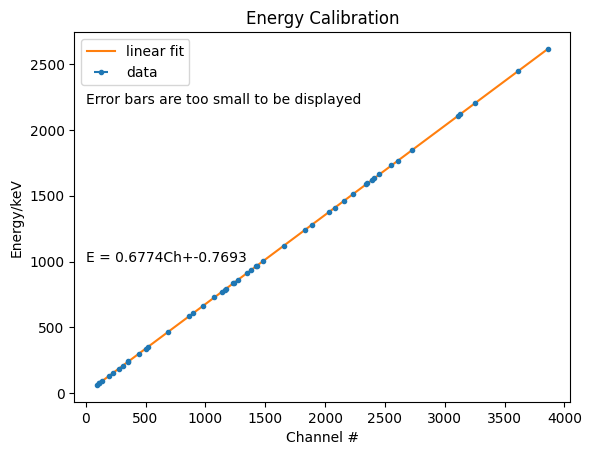

In [10]:
y = ref_1
x = energy_to_chan(centroid_1)
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)
x_err = popt_peak[0]*centroid_1_err
#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,xerr= x_err, fmt = '.',label = 'data')
plt.plot(x,peak_fit(x),label = 'linear fit')
plt.legend()
plt.xlabel('Channel #')
plt.ylabel('Energy/keV')
plt.text(1,1000,f'E = {popt_peak[0]:.4f}Ch+{popt_peak[1]:.4f}')
plt.text(1,2200,'Error bars are too small to be displayed')

In [11]:
print(f'Linear fit (channel to energy) using peak energy: E = {popt_peak[0]:.6f}Ch {popt_peak[1]:.6f}')
print(f'Original linear fit (channel to energy) : E = {grad:.6f}Ch {interc:.6f}' )
print('Errors on new fit:')
print(perr_peak)

Linear fit (channel to energy) using peak energy: E = 0.677361Ch -0.769329
Original linear fit (channel to energy) : E = 0.677523Ch -0.343914
Errors on new fit:
[2.75942194e-05 4.97429035e-02]


Text(0, 0.5, 'Reference Peak Energy-Peak Centroid/keV')

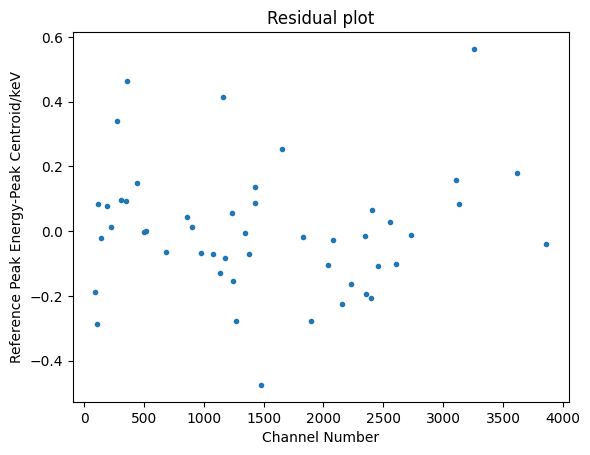

In [12]:
plt.figure()
plt.title('Residual plot')
plt.plot(x,(y-peak_fit(x)),'.')
plt.xlabel('Channel Number')
plt.ylabel('Reference Peak Energy-Peak Centroid/keV')

In [13]:
centroid_1

array([  63.49,   75.55,   77.47,   93.27,  129.44,  154.43,  186.34,
        209.63,  239.02,  242.02,  300.44,  338.83,  352.44,  463.6 ,
        583.71,  609.87,  662.31,  728.  ,  769.1 ,  786.45,  795.65,
        836.28,  841.16,  861.47,  911.85,  934.78,  965.29,  969.54,
       1002.13, 1120.73, 1238.85, 1281.97, 1378.53, 1408.77, 1461.75,
       1510.18, 1589.02, 1593.54, 1621.52, 1631.38, 1662.21, 1730.4 ,
       1765.44, 1848.3 , 2104.3 , 2119.4 , 2204.6 , 2448.69, 2615.62])

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_56047/3279660118.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(a*peak_energy+b)/peak_energy


Text(1600, 0.013, '$R = \\frac{\\sqrt{a * E+b}}{E}$')

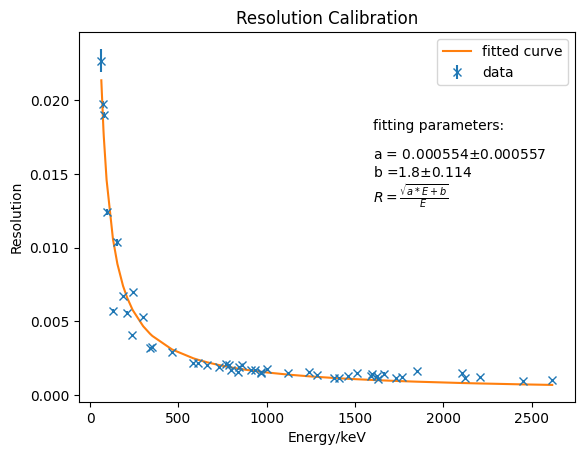

In [14]:
res = fwhm_1/centroid_1
fwhm_1_err= fwhm_1/np.sqrt(2*peak_count_1)

res_err = res*np.sqrt((centroid_1_err/centroid_1)**2+(fwhm_1_err/fwhm_1)**2)
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - fitted centroid of labelled peaks
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy
res_par, res_cov = curve_fit(res_fit,centroid_1,res)
res_fit_err = np.sqrt(np.diag(res_cov))


plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(centroid_1,res,yerr = res_err,fmt = 'x',label = 'data')
plt.plot(centroid_1,res_fit(centroid_1,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Energy/keV')
plt.legend()
plt.text(1600,0.018,f'fitting parameters:')
plt.text(1600,0.016,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.0148,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')
plt.text(1600,0.013,r'$R = \frac{\sqrt{a * E+b}}{E}$')

Text(0, 0.5, 'Resolution Residuals')

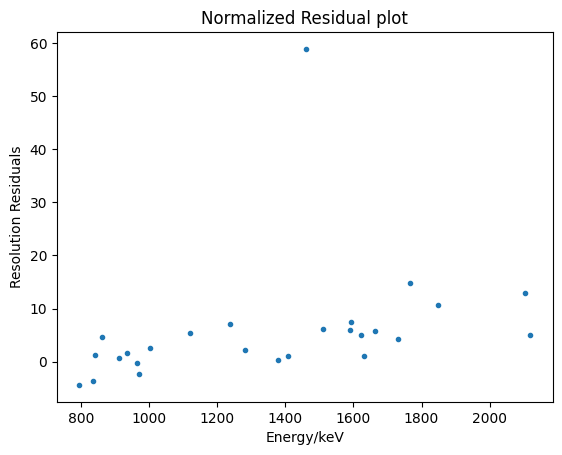

In [15]:
plt.figure()
plt.title('Normalized Residual plot')
plt.plot(centroid_1[20:-3],((res-res_fit(centroid_1,*res_par))/res_err)[20:-3],'.')
plt.xlabel('Energy/keV')
plt.ylabel('Resolution Residuals')

In [16]:
res_fit(centroid_1,2,3)

array([0.17956965, 0.16431108, 0.16222303, 0.14760751, 0.12502091,
       0.11435316, 0.10401667, 0.09802493, 0.09176062, 0.09118661,
       0.08179327, 0.07699868, 0.0754909 , 0.06578771, 0.05861027,
       0.05733632, 0.0550143 , 0.05246821, 0.05104423, 0.05047696,
       0.05018373, 0.04894725, 0.0488048 , 0.04822505, 0.04687165,
       0.04629227, 0.04555366, 0.04545355, 0.04470723, 0.04227221,
       0.04020392, 0.03952119, 0.03811036, 0.03769867, 0.03700847,
       0.03640963, 0.03549402, 0.0354436 , 0.03513619, 0.03502975,
       0.03470307, 0.03401182, 0.03367231, 0.03290826, 0.03084011,
       0.03072997, 0.03012991, 0.02858782, 0.02766   ])

In [30]:
pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals
# pp_df[pp_df['Nuclide'] == 'Pb214']

/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_56047/1394404316.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


,Photopeak_Energy,Nuclide,BR,Dose
620,53.23,Pb214,0.01200,0.00200
882,74.82,Pb214,0.04800,0.01600
929,77.11,Pb214,0.08000,0.02900
1076,86.83,Pb214,0.01000,0.00450
1087,87.35,Pb214,0.01800,0.00830
1129,89.78,Pb214,0.00670,0.00330
1143,90.07,Pb214,0.00170,0.00083
1739,196.20,Pb214,0.00069,0.00094
1916,242.00,Pb214,0.07430,0.10100
1983,258.87,Pb214,0.00524,0.00710


In [38]:
peak_1.rename(columns = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'},inplace = True)
peak_1[1:] = peak_1[1:].astype({'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float}, errors = 'ignore')
df_1 = peak_1[1:].merge(pp_df,on = ['Nuclide','Photopeak_Energy'])  #match BR to peak
Bi214 = df_1[df_1['Nuclide']=='Ac228'][['Photopeak_Energy','Peak_CPS','BR']].to_numpy(dtype = float).transpose()
activity = Bi214[1]/Bi214[2]
activity

array([0.18771468, 0.07696915, 0.05969831, 0.05069091, 0.02771529,
       0.02578882, 0.03633187, 0.03003217, 0.02583367, 0.02489367,
       0.02186615, 0.0228106 ])

In [53]:
np.sqrt(df_1['  Net_Area'].astype(float))


0      20.067386
1      44.289954
2      28.259512
3      54.560059
4      42.003571
5     138.242540
6      68.371778
7      42.225585
8      62.964276
9     106.100895
10     36.253276
11     79.339776
12     91.574560
13    119.363311
14     26.143833
15     26.345778
16     15.642890
17     13.957077
18     25.953805
19     67.569964
20     22.165288
21     27.560842
22     48.141458
23     45.466471
24     28.979303
25     14.404860
26     22.567676
27     16.275749
28    256.090999
29     15.106290
30     20.369094
31     14.247807
32     12.541930
33     44.420716
34     17.317621
35     12.549900
36     24.296090
37     13.758634
38     61.104828
Name:   Net_Area, dtype: float64

In [32]:
peak_1[1:].dtypes

Centroid             object
  Net_Area           object
   Net_Area          object
Peak_CPS             object
 FWHM                object
   FWHM              object
Reduced              object
 ROI_Total           object
ROI                  object
 File                object
                     object
                     object
     .1              object
Nuclide              object
Photopeak_Energy     object
 ROI_Lower_Energy    object
 ROI_Upper_Energy    object
 Color               object
 User_Label          object
 Continuum_Type      object
dtype: object

,Centroid,Net_Area,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,,,.1,Nuclide,Photopeak_Energy,ROI_Lower_Energy,ROI_Upper_Energy,Color,User_Label,Continuum_Type
1,63.49,402.7,98.5,0.000683,1.44,2.27%,1.32,43289.7,1,,589248.000,NaN,NaN,Th234,62.86,54.536,68.0868,#9933FF,NaN,Linear
2,75.55,3838.8,119.4,0.006515,1.49,1.97%,56.12,127454.9,2,,589248.000,NaN,NaN,Pb212 (x-ray),74.82,60.6338,92.4783,#830808,NaN,Linear
3,77.47,4338.5,124.9,0.007363,1.47,1.90%,56.12,127454.9,3,,589248.000,NaN,NaN,Pb212 (x-ray),77.11,60.6338,92.4783,#830808,NaN,Linear
4,93.27,1961.6,124.8,0.003329,1.16,1.24%,20.51,42853.6,4,,589248.000,NaN,NaN,Th234,92.8,88.4131,99.2538,#9933FF,NaN,Linear
5,129.44,771.6,82.1,0.001309,0.74,0.57%,1.22,41468.9,5,,589248.000,NaN,NaN,Ac228,129.06,124.001,133.809,#cc3333,NaN,Linear
6,154.43,798.6,177.6,0.001355,1.60,1.03%,1.51,17018.6,6,,589248.000,NaN,NaN,Ac228,153.98,152.781,156.846,#cc3333,NaN,Linear
7,186.34,2976.8,139.3,0.005052,1.25,0.67%,1.77,46103.3,7,,589248.000,NaN,NaN,Ra226,186.21,179.883,191.402,NaN,NaN,Linear
8,209.63,1764.3,130.3,0.002994,1.17,0.56%,1.33,36381.8,8,,589248.000,NaN,NaN,Ac228,209.25,205.631,215.794,#cc3333,NaN,Linear
9,239.02,19111.0,168.5,0.032433,0.98,0.41%,6.56,83389.6,9,,589248.000,NaN,NaN,Pb212,238.63,229.346,248.996,#830808,NaN,Linear
10,242.02,4674.7,140.8,0.007933,1.69,0.70%,6.56,83389.6,10,,589248.000,NaN,NaN,Pb214,242.0,229.346,248.996,NaN,NaN,Linear


In [62]:
peak_1

,Centroid,Net_Area,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,,,.1,Nuclide,Photopeak_Energy,ROI_Lower_Energy,ROI_Upper_Energy,Color,User_Label,Continuum_Type
0,keV,Counts,Uncertainty,CPS,keV,Percent,Chi_Sqr,Counts,ID#,Name,LiveTime,Date,Time,,keV,keV,keV,(css),,
1,63.49,402.7,98.5,0.000683,1.44,2.27%,1.32,43289.7,1,,589248.000,NaN,NaN,Th234,62.86,54.536,68.0868,#9933FF,NaN,Linear
2,75.55,3838.8,119.4,0.006515,1.49,1.97%,56.12,127454.9,2,,589248.000,NaN,NaN,Pb212 (x-ray),74.82,60.6338,92.4783,#830808,NaN,Linear
3,77.47,4338.5,124.9,0.007363,1.47,1.90%,56.12,127454.9,3,,589248.000,NaN,NaN,Pb212 (x-ray),77.11,60.6338,92.4783,#830808,NaN,Linear
4,93.27,1961.6,124.8,0.003329,1.16,1.24%,20.51,42853.6,4,,589248.000,NaN,NaN,Th234,92.8,88.4131,99.2538,#9933FF,NaN,Linear
5,129.44,771.6,82.1,0.001309,0.74,0.57%,1.22,41468.9,5,,589248.000,NaN,NaN,Ac228,129.06,124.001,133.809,#cc3333,NaN,Linear
6,154.43,798.6,177.6,0.001355,1.60,1.03%,1.51,17018.6,6,,589248.000,NaN,NaN,Ac228,153.98,152.781,156.846,#cc3333,NaN,Linear
7,186.34,2976.8,139.3,0.005052,1.25,0.67%,1.77,46103.3,7,,589248.000,NaN,NaN,Ra226,186.21,179.883,191.402,NaN,NaN,Linear
8,209.63,1764.3,130.3,0.002994,1.17,0.56%,1.33,36381.8,8,,589248.000,NaN,NaN,Ac228,209.25,205.631,215.794,#cc3333,NaN,Linear
9,239.02,19111.0,168.5,0.032433,0.98,0.41%,6.56,83389.6,9,,589248.000,NaN,NaN,Pb212,238.63,229.346,248.996,#830808,NaN,Linear
